In [ ]:
#!pip install -q flwr[simulation] torch torchvision matplotlib

In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Training on cpu using PyTorch 2.0.0+cu117 and Flower 1.4.0


/home/kha053/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading
load  CIFAR-10 dataset to train image classifier

In [1]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


In [4]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)


    # ToDo:  splitting
    #  1 )split the trainset into partitions proportional to the number of clients ,
    #  2) split each of the resulting partitions
    # hint : use teh function random_split(<data>,  <lengths_of_splits>, <random_seed> : torch.Generator.manual_seed(42)
    #)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader



trainloaders, valloaders, testloader = load_datasets()


Files already downloaded and verified
Files already downloaded and verified


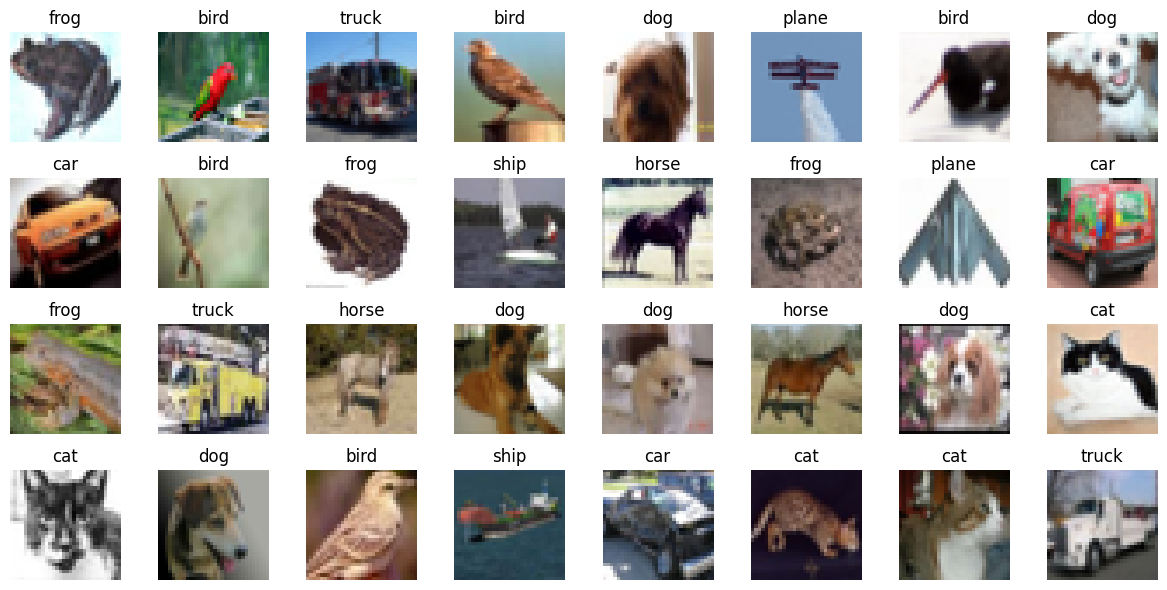

In [5]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()



## Centralized Training

In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [8]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Epoch 1: validation loss 0.06150561141967773, accuracy 0.27
Epoch 2: validation loss 0.05873900175094605, accuracy 0.308
Epoch 3: validation loss 0.05711282539367676, accuracy 0.326
Epoch 4: validation loss 0.05455219292640686, accuracy 0.4
Epoch 5: validation loss 0.0527844820022583, accuracy 0.396
Final test set performance:
	loss 0.049356507229804995
	accuracy 0.4186


## FL Training
 **update the local model with the server parameters**  using the hleper functions `set_parameters` and `get_parameters`.
 - [Pytorch state_dict()](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)
  - [Zip in python](https://soshace.com/python-zip-function-explained-and-visualized/)


In [10]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

### Using the Virtual Client Engine

create flower clients *on demand*  by implementing function that takes the client ID  and returns a FlowerClient


In [13]:
def generate_client(cid: str) -> FlowerClient: #fl.client.NumPyClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)



### start the training

In [14]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=generate_client,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-05-03 12:15:04,357 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-03 12:15:06,393	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-03 12:15:07,269 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 76219424973.0, 'GPU': 2.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 36951182131.0, 'node:140.253.33.60': 1.0}
INFO flwr 2023-05-03 12:15:07,270 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-03 12:15:07,271 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-05-03 12:15:09,494 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-05-03 12:15:09,495 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-03 12:15:09,496 | server.py:101 | FL starting
DEBUG flwr 2023-05-03 12:15:09,497 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 20

History (loss, distributed):
	round 1: 0.06348201656341552
	round 2: 0.05544277434349061
	round 3: 0.05141146011352539
	round 4: 0.049255891275405875
	round 5: 0.04799302453994751

**Behind the scenes** `start_simulation` selects  informs FedAvg that there are 10 clients (num_clients=10) and the FedAvg strategy to selects 100% of them. Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (FedAvg) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.


### Matrics Aggregation


In [15]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [16]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=generate_client,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-03 12:18:56,160 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-03 12:19:00,107	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-03 12:19:00,998 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:140.253.33.60': 1.0, 'memory': 76223834727.0, 'CPU': 8.0, 'GPU': 2.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 36953072025.0}
INFO flwr 2023-05-03 12:19:00,999 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-03 12:19:00,999 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-05-03 12:19:03,166 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-05-03 12:19:03,167 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-03 12:19:03,168 | server.py:101 | FL starting
DEBUG flwr 2023-05-03 12:19:03,170 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 20

History (loss, distributed):
	round 1: 0.06354821925163269
	round 2: 0.0556429530620575
	round 3: 0.05259279932975769
	round 4: 0.0501891879081726
	round 5: 0.04940566878318787
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.29640000000000005), (2, 0.3532), (3, 0.38519999999999993), (4, 0.41), (5, 0.41479999999999995)]}